10.0 % | est. time left: 23
20.0 % | est. time left: 20
30.0 % | est. time left: 18
40.0 % | est. time left: 15
50.0 % | est. time left: 13
60.0 % | est. time left: 10
70.0 % | est. time left: 8
80.0 % | est. time left: 5
90.0 % | est. time left: 3
100.0 % | est. time left: 0


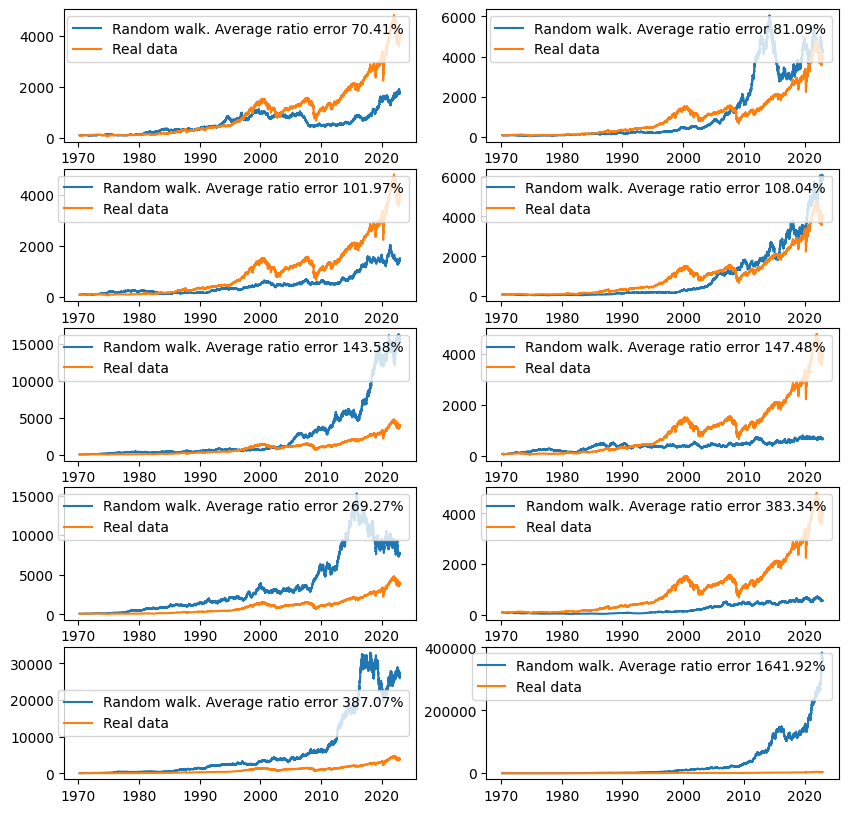

In [18]:
import yahoo_fin.stock_info as si
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

# Get the daily stock prices for the S&P 500 index from Yahoo Finance
ticker = "^GSPC"
runs = 1000
runs_to_plot = 10
df = si.get_data(ticker)

# Calculate the daily returns
returns = df["adjclose"].pct_change().dropna()

# Fit a Gaussian distribution to the daily returns
mu, std = norm.fit(returns)

# Generate 10 random walks through the matrix, starting at the same point as the real data
best_random_walks = []
start_index = np.where(returns == returns.iloc[0])[0][0]
start_time = time.time()
for run in range(1, runs + 1):
    # Time calculation
    if runs > 100:
      if run % round(runs / 10) == 0:
        print(run * 100 / runs, '% | est. time left:', round((time.time() - start_time) * (runs - run) / run), 's')
    
    current_return = returns.iloc[start_index]
    random_walk = [df["adjclose"].iloc[start_index]]
    for _ in range(len(df) - start_index - 1):
        # Sample a random return from the Gaussian distribution
        next_return = np.random.normal(mu, std)
        current_price = random_walk[-1]
        next_price = current_price * (1 + next_return)
        random_walk.append(next_price)
    # Calculate accuracy
    ratios = [fraction if (fraction := random_walk[i] / df["adjclose"][i]) > 1 else 1 / fraction for i in range(len(random_walk))]
    average_ratio = sum(ratios) / len(ratios) - 1
    if len(best_random_walks) < runs_to_plot:
        best_random_walks.append((average_ratio, random_walk))
        continue
    if average_ratio > best_random_walks[-1][0]:
        best_random_walks[-1] = (average_ratio, random_walk)
        best_random_walks.sort(key=lambda pair: pair[0])

best_random_walks = [(acc, pd.Series(walk, index=df.index)) for acc, walk in best_random_walks]

# Create a grid of subplots
fig, ax = plt.subplots(nrows=-(-runs_to_plot // 2), ncols=2, figsize=(10, 10))



# Plot each random walk and the real data on a separate subplot
for i, (accuracy, random_walk) in enumerate(best_random_walks):
    ax[i//2, i%2].plot(random_walk, label=f"Random walk. Average ratio error {accuracy:.2%}")
    ax[i//2, i%2].plot(df["adjclose"], label="Real data")
    ax[i//2, i%2].legend()

plt.show()
